In [1]:
import pytesseract
from PIL import Image,ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def crop_book_page(image_path):
    im = cv2.imread(image_path)
    print(im.shape[:2])
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        cropped = im[y:y+h, x:x+w]
        print(cropped.shape[:2])

        return cropped
    else:
        print("No contours found. Returning original image.")
        return im

input_image_path = 'test4.jpg'
image = crop_book_page(input_image_path)

(3425, 2570)
1
(3425, 2570)


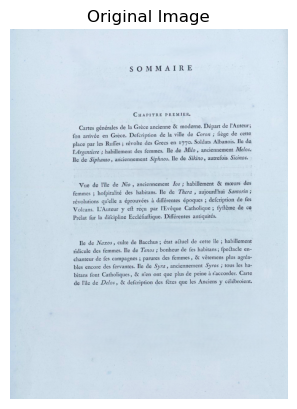

In [3]:
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
height , width = gray_image.shape[:2]

In [6]:
data = pytesseract.image_to_data(gray_image, output_type=pytesseract.Output.DICT, lang='fra')
n_boxes = len(data['level'])

In [7]:
mask = np.zeros_like(gray_image)
for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    if w > 0 and h > 0 and w<width and h<height:  # Ensure the width and height are positive
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)  # Fill the rectangle with white

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
clean_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

In [9]:
cv2.imwrite('masked_image.jpg', clean_mask)

True

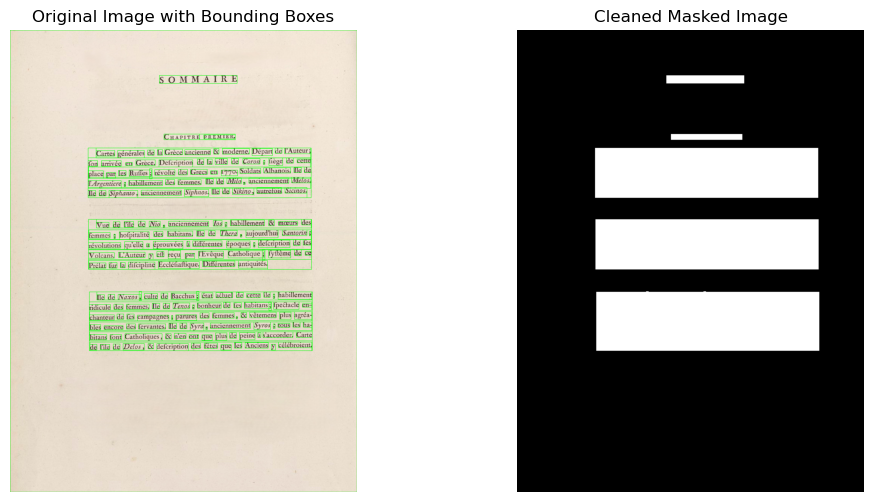

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    if w > 0 and h > 0:  
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image with Bounding Boxes')

ax[1].imshow(clean_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Cleaned Masked Image')

plt.show()

In [11]:
text = pytesseract.image_to_string(gray_image, lang='fra')

In [12]:
print(f"Reference: {text}")

Reference: SOMMAIRE

CHAPITRE PREMIER.

Cartes générales de la Grèce ancienne & moderne. Départ de l’Auteur;
fon arrivée en Grèce. Defcription de la ville de Coron ; fiège de cette
place par les Ruffes ; révolte des Grecs en 1770- Soldats Albanois. Ile de
l’Argentiere ; habillement des femmes. Ile de Milo , anciennement Melos.
Ie de Siphanto, anciennement Siphnos. Ile de Sikino, autrefois Sicinos.

Vue de l'ile de Nio , anciennement Tos ; habillement & mœurs des
femmes ; hofpitalité des habitans. He de Thera , aujourd'hui Santorin ;
révolutions qu’elle a éprouvées à différentes époques ; defcription de fes
Volcans. L’Auteur y eft reçu par l'Evêque Catholique ; fyftême de ce
Prélat fur la difcipline Eccléfiaftique. Différentes antiquités.

Ile de Naxos , culte de Bacchus ; état aQuel de cette île ; habillement
ridicule des femmes. Ile de Tenos ; bonheur de fes habitans ; fpectacle en-
chanteur de fes campagnes ; parures des femmes , & vêtemens plus agréa-
bles encore des fervantes. Ile 

## Translation

In [13]:
from transformers import MarianMTModel, MarianTokenizer

model_name = 'Helsinki-NLP/opus-mt-fr-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

C:\Users\pavan\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\pavan\AppData\Roaming\Python\Python311\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
def translate(text, model, tokenizer, max_length=512):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    
    translated_tokens = model.generate(**inputs)
    
    translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    return translated_text[0]

In [15]:
def split_text(text, tokenizer, max_length=512):
    paragraphs = text.split('\n\n')  
    chunks = []

    for paragraph in paragraphs:
        words = paragraph.split()
        current_chunk = []

        for word in words:
            current_chunk.append(word)
            if len(tokenizer(' '.join(current_chunk))['input_ids']) >= max_length:
                current_chunk.pop()  
                chunks.append(' '.join(current_chunk))
                current_chunk = [word]  
        
        if current_chunk:
            chunks.append(' '.join(current_chunk))


    return chunks

In [16]:
chunks = split_text(text, tokenizer)
english_translations = [translate(chunk, model, tokenizer) if chunk else '' for chunk in chunks]
full_translation = '\n\n'.join(english_translations)  
print(full_translation)

CONTENTS

CHAPTER I.

General maps of ancient and modern Greece. Departure of the Author; arriving in Greece. Defecription of the city of Coron; fencing of this square by the Ruffes; revolt of the Greeks in 1770- Albanois Soldiers. Argentiere Island; women's clothing. Milo Island, formerly Melos. The Siphanto Island, formerly Siphnos. Sikino Island, formerly Sicinos.

View of the island of Nio, formerly Tos ; clothing & manners of women ; heh of Thera, today Santorini ; revolutions that she experienced at different times ; defcription of Volcans' fes. L-Author y eft received by the Catholic Bishop ; fyfte of this Prelate in the Ecclefiaftic difcipline. Different antiquities.

Ile de Naxos, cult of Bacchus ; state aWhat of this island ; ridiculous clothing of women. Ile de Tenos ; happiness of fes habitans ; fpectacle en- chanter de fes rurales ; adornments of women, & clothing more acceptable- still fervents. Ile de Syra, formerly Syros ; all ha-banans do Catholics, & n'en have only mo

### Evalutaion of translation

In [17]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
import sacrebleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
def calculate_metrics(reference, hypothesis):
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    nltk_bleu = sentence_bleu([reference_tokens], hypothesis_tokens)
    
    references = [reference]
    hypotheses = [hypothesis]
    
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    
    chrf = sacrebleu.sentence_chrf(hypothesis, [reference])
    
    ter = sacrebleu.sentence_ter(hypothesis, [reference])
        
    return {
        'NLTK BLEU': nltk_bleu,
        'sacreBLEU': bleu.score,
        'chrF': chrf.score,
        'TER': ter.score,
    }

# Calculate metrics
metrics = calculate_metrics(text, full_translation)

# Print results
print(f"Reference: {text}")
print(f"Hypothesis: {full_translation}")
print("\nMetrics:")
for metric, score in metrics.items():
    print(f"{metric}: {score}")

Reference: SOMMAIRE

CHAPITRE PREMIER.

Cartes générales de la Grèce ancienne & moderne. Départ de l’Auteur;
fon arrivée en Grèce. Defcription de la ville de Coron ; fiège de cette
place par les Ruffes ; révolte des Grecs en 1770- Soldats Albanois. Ile de
l’Argentiere ; habillement des femmes. Ile de Milo , anciennement Melos.
Ie de Siphanto, anciennement Siphnos. Ile de Sikino, autrefois Sicinos.

Vue de l'ile de Nio , anciennement Tos ; habillement & mœurs des
femmes ; hofpitalité des habitans. He de Thera , aujourd'hui Santorin ;
révolutions qu’elle a éprouvées à différentes époques ; defcription de fes
Volcans. L’Auteur y eft reçu par l'Evêque Catholique ; fyftême de ce
Prélat fur la difcipline Eccléfiaftique. Différentes antiquités.

Ile de Naxos , culte de Bacchus ; état aQuel de cette île ; habillement
ridicule des femmes. Ile de Tenos ; bonheur de fes habitans ; fpectacle en-
chanteur de fes campagnes ; parures des femmes , & vêtemens plus agréa-
bles encore des fervantes. Ile 

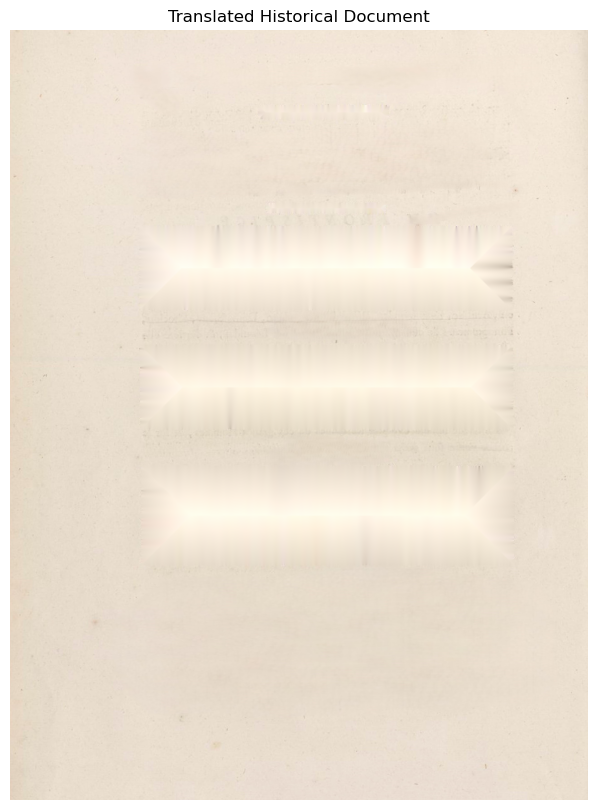

In [19]:
image = cv2.imread('test4.jpg')
mask = cv2.imread('masked_image.jpg', 0) 
inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  # Hide axes
plt.title('Translated Historical Document')
plt.show()

In [20]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

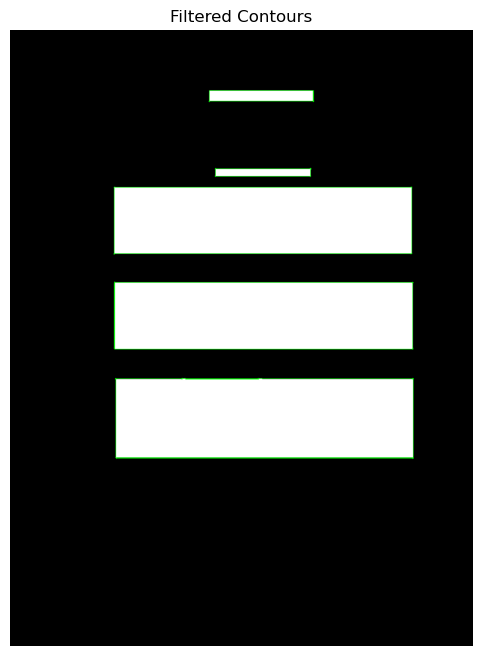

Number of filtered contours: 5


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

contour_areas = [cv2.contourArea(cnt) for cnt in contours]

filtered_contours_areas = [area for area in contour_areas if area > 0]

Q1 = np.percentile(filtered_contours_areas, 10)
filtered_contours = [cnt for cnt in contours if Q1 < cv2.contourArea(cnt)]

filtered_contour_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
cv2.drawContours(filtered_contour_image, filtered_contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Contours')
plt.axis('off')
plt.show()

print(f"Number of filtered contours: {len(filtered_contours)}")

In [22]:
detection_data = pytesseract.image_to_boxes(image)
lines = detection_data.strip().splitlines()
heights = []

for line in lines:
    _, x1, y1, x2, y2, _ = line.split()
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    heights.append(y2 - y1)

median_height = np.median(heights)

img_height, img_width = image.shape[:2]

font_size = (median_height)  


In [23]:
font_size

28.0

In [24]:
filtered_contours = filtered_contours[::-1]

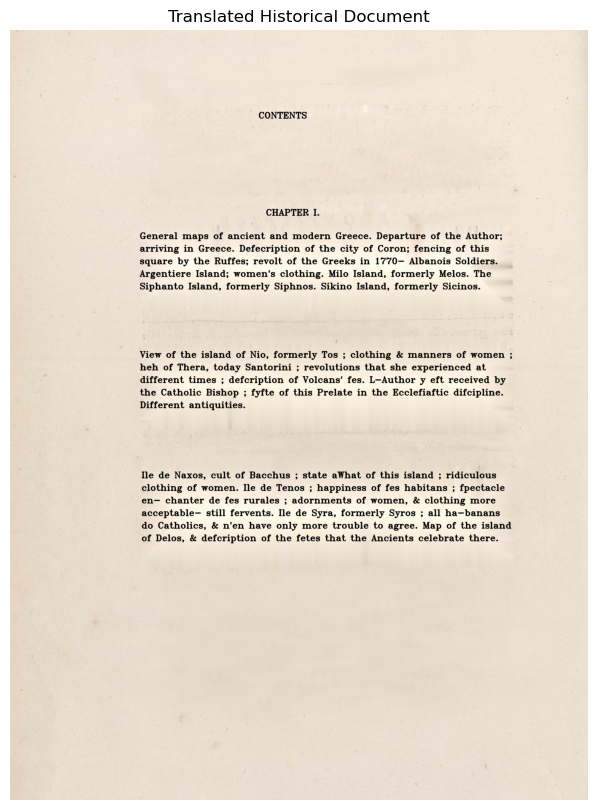

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

inpainted_image_new = inpainted_image[::]
def wrap_text(text, font, font_size, max_width):
    lines = []
    words = text.split(' ')
    current_line = ''
    font_scale = calculate_font_scale(font, font_size)
    for word in words:
        test_line = f"{current_line} {word}".strip()
        (text_width, _), _ = cv2.getTextSize(test_line, font, font_scale, 1)
        if text_width <= max_width:
            current_line = test_line
        else:
            if current_line:
                lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return lines

def calculate_font_scale(font, desired_font_size):
    (text_width, text_height), baseline = cv2.getTextSize('A', font, 1.0, 1)
    
    font_scale = desired_font_size / text_height
    return font_scale

paragraphs = full_translation.split("\n\n")

font = cv2.FONT_HERSHEY_TRIPLEX
font_color = (0, 0, 0)
line_type = cv2.LINE_AA
thickness = 2
line_spacing = 2  

if len(paragraphs) > len(filtered_contours):
    print("Warning: More paragraphs than boxes. Some text may not be placed.")
    
for paragraph, contour in zip(paragraphs, filtered_contours):
    x, y, w, h = cv2.boundingRect(contour)
    
    wrapped_lines = wrap_text(paragraph, font, font_size, w)
    
    font_scale = calculate_font_scale(font, font_size)
    line_height = cv2.getTextSize('A', font, font_scale, 1)[0][1]  
    adjusted_line_height = int(line_height * line_spacing) 
    
    start_y = y + adjusted_line_height
    
    for i, line in enumerate(wrapped_lines):
        (text_width, text_height), baseline = cv2.getTextSize(line, font, font_scale, 1)
        text_x = x
        text_y = start_y + i * adjusted_line_height
        
        if text_y + text_height > y + h:
            while text_y + text_height < y + h:
                font_size = font_size-1
                (text_width, text_height), baseline = cv2.getTextSize(line, font, calculate_font_scale(font, font_size), 1)
                text_x = x
                text_y = start_y + i * adjusted_line_height
                print(text_y + text_height , y + h)
            
        
        cv2.putText(inpainted_image_new, line, (text_x, text_y), font, font_scale, font_color, thickness, line_type)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(inpainted_image_new, cv2.COLOR_BGR2RGB))  
plt.axis('off')  # Hide axes
plt.title('Translated Historical Document')
plt.show()

